In [1]:
def Peak_integrate(wavelength,spec,aim_peak,tol = 1):#已知峰，寻峰面积
    #aim_peak 是一个list或者array
    p = []
    m = []
    if tol == 0:
        return [1 for _ in range(len(aim_peak))],[0 for _ in range(len(aim_peak))],np.where(np.isin(wavelength,aim_peak))[0]
    if isinstance(aim_peak,list):
        aim_peak_arr = np.asarray(aim_peak)
        return Peak_integrate(wavelength,spec,aim_peak_arr,tol)
    elif isinstance(aim_peak,np.ndarray):
        WL_list = np.where(np.isin(wavelength,aim_peak))[0]
        for i in range(len(WL_list)):
        #设定容错为1寻找最小值
            p.append(step('right',spec,tol,WL_list[i]))
            m.append(step('left',spec,tol,WL_list[i]))
       
        return p,m,WL_list
    else:
        print('aim_peak must be a list or array')
        return

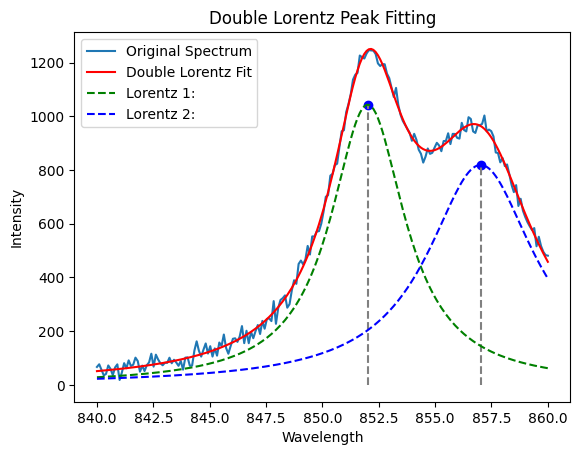

Fit parameters: [ 852.01082147 1043.17596691    2.01211232  857.02007526  818.78548733
    2.88415676]


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# 定义Lorentzian函数
def lorentzian(x, x0, A, gamma):
    return A * gamma**2 / ((x - x0)**2 + gamma**2)

# 定义双Lorentzian函数作为拟合模型
def double_lorentzian(x, x1, A1, gamma1, x2, A2, gamma2):
    return lorentzian(x, x1, A1, gamma1) + lorentzian(x, x2, A2, gamma2)

# 生成模拟的光谱数据
x_data = np.linspace(840, 860, 200)
true_params = [852, 1024, 2, 857, 819, 3]  
y_data = double_lorentzian(x_data, *true_params) + np.random.normal(0, 20, len(x_data))  

wavelength = x_data
intensity = y_data

# 进行拟合
initial_guess = [852, 1024, 2, 857, 819, 3]  
fit_params, _ = curve_fit(double_lorentzian, wavelength, intensity, p0=initial_guess,maxfev = 50000)

# 绘制拟合结果
plt.plot(wavelength, intensity, label='Original Spectrum')
fit_curve = double_lorentzian(wavelength, *fit_params)
plt.plot(wavelength, fit_curve, color='red', label='Double Lorentz Fit')

# 标注峰的位置
for i in range(0, len(fit_params), 3):
    peak_position = fit_params[i]
    peak_intensity = lorentzian(peak_position, *fit_params[i:i+3])
    
    plt.plot(peak_position, peak_intensity, 'bo')  # 标注峰的位置
    
    # 绘制垂直虚线
    plt.plot([peak_position, peak_position], [0, peak_intensity], color='gray', linestyle='--')

    # 添加标签
    #plt.text(peak_position, peak_intensity, f'({peak_position:.1f}, {peak_intensity:.1f})', fontsize=9, color='blue')


plt.plot(wavelength, lorentzian(wavelength, fit_params[0], fit_params[1], fit_params[2]),
         linestyle='dashed', color='green', label='Lorentz 1 ')
plt.plot(wavelength, lorentzian(wavelength, fit_params[3], fit_params[4], fit_params[5]),
         linestyle='dashed', color='blue', label='Lorentz 2 ')

plt.legend()
plt.xlabel('Wavelength')
plt.ylabel('Intensity')
plt.title('Double Lorentz Peak Fitting')

plt.show()

print('Fit parameters:', fit_params)



In [2]:
'''
:@Author: Remi
:@Date: 2023/11/15 15:42:40
:@LastEditors: Remi
:@LastEditTime: 2023/12/26 16:46:05
:Description: 
'''
import pandas as pd
import seaborn as sns
import file_tool as ft
import numpy as np
import preprocessing as pp
import matplotlib.pyplot as plt
'''
保存格式：
eg：csv中

1223  1231  123  2323
123    213  123  23123

代表两个sample对应四个峰的峰面积
'''
################cache/需要改的
conc = []

np.set_printoptions(precision = 6)

peak_list = [779.989,852.075]##############peak position
tol = 0#算峰面积的容差


##################path##########################
filename = r'D:\20231218\internal_stand\3N\internal_wei.csv'#file position
savepath = r'D:\20231218\internal_stand\3N'
##################load#########################

wl,spec=ft.Load_MultiSpec(filename)

meanspec = np.mean(spec,axis = 1)############while variable no_grad use mean spec , otherwise chose max spec 
maxspec = np.min(spec,axis = 1)

p,m,peak_list = Peak_integrate(wl,maxspec,peak_list,tol)


In [ ]:

##################calculate#####################
for i in range(len(spec[0])):
    for j in range(len(peak_list)):#pm wavelength
        if(p[j] + m[j]) == 1:
            slice_cache = spec[peak_list[j],i]
        else:
            slice_cache = spec[peak_list[j] - m[j]:peak_list[j] + p[j],i]
            slice_square = (p[j] + m[j]) * (slice_cache[0] + slice_cache[-1])/2

        if j == 0:
            slice_ = slice_cache.sum(axis=0) - slice_square
        else:
            slice_ = np.vstack((slice_,(slice_cache.sum(axis=0) - slice_square)))

        if i == 0:
            conc.append(wl[peak_list[j]])

    if i == 0:
        slice_sample = slice_   
    else: 
        slice_sample = np.hstack((slice_sample,slice_))

###################save#####################################



###################plot#####################################

for j in range(len(peak_list)):
    sns_spec = spec[:][peak_list[j] - m[j]:peak_list[j] + p[j],:]
    sns_wl = wl_cache = wl[peak_list[j] - m[j]:peak_list[j] + p[j]]

##################减阴影
    for i in range(len(sns_spec[0,:])):
        slope = (sns_spec[:,i][0] - sns_spec[:,i][-1])/(sns_wl[0] - sns_wl[-1])
        bias = sns_spec[:,i][0] - slope * sns_wl[0]
        sns_spec[:,i] = sns_spec[:,i] - (sns_wl * slope + bias)

# ##################展区间  画带SD的图
#     for i in range(len(sns_spec[0][:]) - 1):
#         sns_wl = np.column_stack((sns_wl,wl_cache))

#     sns_spec = sns_spec.flatten()
#     sns_wl = sns_wl.flatten()
#     data = np.column_stack((sns_wl, sns_spec))
#     df = pd.DataFrame(data, columns=['wl', 'int'])
#     sns.relplot(x="wl", y="int", kind="line", data=df,ci = "sd")
#     sns.relplot(x="wl", y="int", kind="line", data=df)
#     plt.show()
##################### 画不同浓度梯度的图
    with plt.style.context('ggplot'):
        linespace = len(sns_spec[0,:])
        for colors in range(linespace):
            plt.plot(sns_wl,sns_spec[:,colors],color= plt.get_cmap('Blues')((np.linspace(0, 1, linespace)))[colors])
        plt.xlabel("Wl")
        plt.ylabel("I")
        plt.show()
